Call salsa model

Call kayla model

Shulha class

Andhita class

Machine learning

analysis summary

yg kita ml isina cuma title content feature score 4 kita

ml2 isinya smua sumber jam tgl alalla gajelas itu sm 4 kita

title | content | entity_consistency_score | main_entity_coverage |  main_entity_consistency_score |style_label | confidence_score_style_label | probability_each_style | stance | stance_confidence | probability_each_stance | qa_prediction_score

# Imports Each Pipeline Task

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, pipeline, BitsAndBytesConfig, AutoModelForQuestionAnswering
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import torch
import zipfile
import os
import re
import gdown
import warnings

from typing import List, Dict, Set, Optional
from peft import PeftModel, PeftConfig
warnings.filterwarnings("ignore")

In [4]:
def download_and_extract_model(gdrive_url: str, output_zip_file: str, extraction_dir: str) -> str:
    gdown.download(gdrive_url, output_zip_file, fuzzy=True)

    os.makedirs(extraction_dir, exist_ok=True)

    with zipfile.ZipFile(output_zip_file, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)

    print(f"Model extracted to: {extraction_dir}")

    actual_model_path = None

    for root, dirs, files in os.walk(extraction_dir):
        if 'config.json' in files or 'adapter_config.json' in files:
            actual_model_path = root
            print(f"Model config found in: {actual_model_path}. Using this path.")
            break

    if not actual_model_path:
        print("Could not determine the correct model path. Please inspect the directory structure manually.")
        print(f"Contents of {extraction_dir}: {os.listdir(extraction_dir)}")
        raise ValueError("Could not determine the correct model path after extraction.")

    return actual_model_path

## Headline Analyzer

In [5]:
label_list = ["sensational", "factual", "opinionated", "curiosity-based"]
label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}
class HeadlineStylePredictor:
    def __init__(self, model_dir, id_to_label, max_length=128):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        self.model.to(self.device)
        self.model.eval()
        self.id_to_label = id_to_label
        self.max_length = max_length

    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = self.model(**inputs).logits
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(np.argmax(probs))
        return self.id_to_label[pred_id], float(probs[pred_id])

    def predict_with_vector(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = self.model(**inputs).logits
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(np.argmax(probs))
        label = self.id_to_label[pred_id]
        return label, float(probs[pred_id]), probs.tolist()

In [6]:
headline_model_gdrive_url = 'https://drive.google.com/file/d/1zwMtnIxtbCqEyYHDswDQIpNR7CCS7E6Y/view?usp=drive_link'
headline_output_zip_file = 'headline_analyzer_indobert_large.zip'
headline_extraction_dir = './headline_analyzer_model/models/IndoBERT-Large'

HEADLINE_ANALYZER_MODEL_PATH = download_and_extract_model(
    headline_model_gdrive_url,
    headline_output_zip_file,
    headline_extraction_dir
)

print(f"Final HEADLINE_ANALYZER_MODEL_PATH: {HEADLINE_ANALYZER_MODEL_PATH}")

Downloading...
From (original): https://drive.google.com/uc?id=1zwMtnIxtbCqEyYHDswDQIpNR7CCS7E6Y
From (redirected): https://drive.google.com/uc?id=1zwMtnIxtbCqEyYHDswDQIpNR7CCS7E6Y&confirm=t&uuid=868fe12e-f74b-4fff-8835-fe5027303ad3
To: /content/headline_analyzer_indobert_large.zip
100%|██████████| 1.24G/1.24G [00:12<00:00, 96.0MB/s]


Model extracted to: ./headline_analyzer_model/models/IndoBERT-Large
Model config found in: ./headline_analyzer_model/models/IndoBERT-Large/models/IndoBERT-Large. Using this path.
Final HEADLINE_ANALYZER_MODEL_PATH: ./headline_analyzer_model/models/IndoBERT-Large/models/IndoBERT-Large


In [7]:
headline_predictor = HeadlineStylePredictor(HEADLINE_ANALYZER_MODEL_PATH, id_to_label, max_length=128)

print("Headline Predictor initialized and ready for use!")

text_to_predict = "Korupsi Merajalela, Rakyat Menjerit!"
style, confidence = headline_predictor.predict(text_to_predict)
print(f"Text: '{text_to_predict}'")
print(f"Predicted Style: {style} (Confidence: {confidence:.4f})")

text_to_predict_2 = "Penelitian Terbaru Ungkap Manfaat Tersembunyi Kopi"
style_2, confidence_2 = headline_predictor.predict(text_to_predict_2)
print(f"\nText: '{text_to_predict_2}'")
print(f"Predicted Style: {style_2} (Confidence: {confidence_2:.4f})")

Headline Predictor initialized and ready for use!
Text: 'Korupsi Merajalela, Rakyat Menjerit!'
Predicted Style: sensational (Confidence: 0.9903)

Text: 'Penelitian Terbaru Ungkap Manfaat Tersembunyi Kopi'
Predicted Style: factual (Confidence: 0.9996)


## Stance Detector


In [8]:
class StanceDetector:
    def __init__(self, model_path, use_length_markers=True):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Loading model on {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

        self.label2id = {'Agrees': 0, 'Disagrees': 1, 'Discusses': 2}
        self.id2label = {0: 'Agrees', 1: 'Disagrees', 2: 'Discusses'}
        self.use_length_markers = use_length_markers

    def _add_length_marker(self, content):
        if not self.use_length_markers:
            return ""

        content_len = len(content)
        if content_len > 2300:
            return "[LONG]"
        elif content_len > 1500:
            return "[MEDIUM]"
        else:
            return "[SHORT]"

    def predict(self, title, content, return_all_scores=False):
        length_marker = self._add_length_marker(content)
        text = f"{length_marker} {title} [SEP] {content[:1000]}"

        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=-1)

        probs = probabilities[0].cpu().numpy()
        predicted_class = np.argmax(probs)
        confidence = probs[predicted_class]

        result = {
            'stance': self.id2label[predicted_class],
            'confidence': round(float(confidence), 4)
        }

        if return_all_scores:
            result['all_scores'] = {
                self.id2label[i]: round(float(prob), 4)
                for i, prob in enumerate(probs)
            }

        return result

    def predict_batch(self, titles, contents, batch_size=16, return_all_scores=False):
        results = []

        for i in range(0, len(titles), batch_size):
            batch_titles = titles[i:i+batch_size]
            batch_contents = contents[i:i+batch_size]

            texts = []
            for title, content in zip(batch_titles, batch_contents):
                length_marker = self._add_length_marker(content)
                text = f"{length_marker} {title} [SEP] {content[:1000]}"
                texts.append(text)

            inputs = self.tokenizer(
                texts,
                return_tensors='pt',
                truncation=True,
                max_length=512,
                padding=True
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs)
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)

            for j in range(len(batch_titles)):
                probs = probabilities[j].cpu().numpy()
                predicted_class = np.argmax(probs)

                result = {
                    'stance': self.id2label[predicted_class],
                    'confidence': round(float(probs[predicted_class]), 4)
                }

                if return_all_scores:
                    result['all_scores'] = {
                        self.id2label[k]: round(float(v), 4)
                        for k, v in enumerate(probs)
                    }

                results.append(result)

        return results

In [9]:
stance_model_gdrive_url = 'https://drive.google.com/file/d/1DrNzeuxeiAMRKSem93y9hjywqkJSD6kF/view?usp=drive_link'
stance_output_zip_file = 'stance_detector_model.zip'
stance_extraction_dir = './stance_detector_model/models/IndoBERT/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228'
# stance_extraction_dir = './stance_detector_model/models/IndoBERT/model_indobert/checkpoint-4000'
STANCE_DETECTOR_MODEL_PATH = download_and_extract_model(
    stance_model_gdrive_url,
    stance_output_zip_file,
    stance_extraction_dir
)

print(f"Final STANCE_DETECTOR_MODEL_PATH: {STANCE_DETECTOR_MODEL_PATH}")

Downloading...
From (original): https://drive.google.com/uc?id=1DrNzeuxeiAMRKSem93y9hjywqkJSD6kF
From (redirected): https://drive.google.com/uc?id=1DrNzeuxeiAMRKSem93y9hjywqkJSD6kF&confirm=t&uuid=3e2a1165-f8b0-4dd3-a13b-fd66146a1e9e
To: /content/stance_detector_model.zip
100%|██████████| 2.37G/2.37G [00:38<00:00, 60.8MB/s]


Model extracted to: ./stance_detector_model/models/IndoBERT/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228
Model config found in: ./stance_detector_model/models/IndoBERT/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228. Using this path.
Final STANCE_DETECTOR_MODEL_PATH: ./stance_detector_model/models/IndoBERT/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228/model_indobert/checkpoint-4228


In [10]:
stance_detector = StanceDetector(STANCE_DETECTOR_MODEL_PATH, use_length_markers=True)

title_example = "Global warming is a hoax"
content_example = "A new report suggests that recent temperature increases are part of natural climate cycles, not human activity."

result = stance_detector.predict(title_example, content_example, return_all_scores=True)
print(f"\nStance Detector Result for: '{title_example}'")
print(f"Content: '{content_example[:50]}...'\n")
print(f"Stance: {result['stance']} (Confidence: {result['confidence']})")
print(f"All Scores: {result['all_scores']}")

Loading model on cuda

Stance Detector Result for: 'Global warming is a hoax'
Content: 'A new report suggests that recent temperature incr...'

Stance: Discusses (Confidence: 0.9874)
All Scores: {'Agrees': 0.0112, 'Disagrees': 0.0014, 'Discusses': 0.9874}


## Spoiler Generator


In [11]:
class SpoilerDetector:
    def __init__(self, model_path=None):
        self.model_path = model_path if model_path else "Rifky/Indobert-QA"
        self.pipeline = None
        self._load_model()

    def _load_model(self):
        print(f"Loading Spoiler QA Model: {self.model_path}...")
        try:
            self.pipeline = pipeline("question-answering", model=self.model_path, device=0)
        except:
            print("GPU not found or error loading on GPU. Switching to CPU.")
            self.pipeline = pipeline("question-answering", model=self.model_path, device=-1)
        print("Model loaded.")

    def predict(self, headline, content):
        if not content or not isinstance(content, str) or not headline:
            return 0.0, ""

        question_text = f"Jelaskan {headline}"
        context_text = content[:2000]

        try:
            res = self.pipeline(
                question=question_text,
                context=context_text,
                truncation="only_second",
                max_length=512
            )

            raw_score = res['score']
            answer_text = res['answer']
            start_index = res['start']

            final_score = raw_score
            if start_index < 500 and raw_score > 0:
                final_score = min(0.99, raw_score * 1.2)

            return final_score, answer_text

        except Exception as e:
            return 0.0, ""

def get_spoiler_features(df):
    """
    Main entry point. Takes a DataFrame containing 'title' and 'content'.
    Returns the DataFrame with new columns: 'spoiler_score' and 'spoiler_answer'.
    """
    detector = SpoilerDetector(model_path=globals().get('SPOILER_DETECTOR_MODEL_PATH'))

    print(f"Extracting spoiler features for {len(df)} articles...")

    scores = []
    answers = []

    for index, row in df.iterrows():
        if index % 50 == 0 and index > 0:
            print(f"Processed {index} rows...", end="\r")

        s, a = detector.predict(row['title'], row['content'])
        scores.append(s)
        answers.append(a)

    df['spoiler_score'] = scores
    df['spoiler_answer'] = answers

    print(f"\nDone! Features added.")
    return df

In [12]:
spoiler_model_gdrive_url = 'https://drive.google.com/file/d/1sso1pAxYM1faZ-45kEnraFq5sDj8E2bh/view?usp=drive_link'
spoiler_output_zip_file = 'spoiler_detector_model.zip'
spoiler_extraction_dir = './spoiler_detector_model_extracted'

SPOILER_DETECTOR_MODEL_PATH = download_and_extract_model(
    spoiler_model_gdrive_url,
    spoiler_output_zip_file,
    spoiler_extraction_dir
)

print(f"Final SPOILER_DETECTOR_MODEL_PATH: {SPOILER_DETECTOR_MODEL_PATH}")

Downloading...
From (original): https://drive.google.com/uc?id=1sso1pAxYM1faZ-45kEnraFq5sDj8E2bh
From (redirected): https://drive.google.com/uc?id=1sso1pAxYM1faZ-45kEnraFq5sDj8E2bh&confirm=t&uuid=ce4ecf7f-3082-41a1-ab7a-e635a552097d
To: /content/spoiler_detector_model.zip
100%|██████████| 169M/169M [00:02<00:00, 59.0MB/s]


Model extracted to: ./spoiler_detector_model_extracted
Model config found in: ./spoiler_detector_model_extracted. Using this path.
Final SPOILER_DETECTOR_MODEL_PATH: ./spoiler_detector_model_extracted


In [13]:
spoiler_detector = SpoilerDetector()

headline_ex = "Kucing Berbicara Memecahkan Misteri Hilangnya Sepeda"
content_ex = "Seekor kucing dengan kemampuan bicara unik bernama Whiskers membantu detektif lokal menyelidiki kasus pencurian sepeda yang membingungkan. Whiskers memberikan petunjuk penting yang mengarah pada penangkapan pelakunya, yaitu seekor burung beo yang cemburu."

score, answer = spoiler_detector.predict(headline_ex, content_ex)
print(f"\nSpoiler Detector Result for: '{headline_ex}'")
print(f"Content (excerpt): '{content_ex[:100]}...'\n")
print(f"Spoiler Score: {score:.4f}")
print(f"Spoiler Answer: {answer}")

Loading Spoiler QA Model: Rifky/Indobert-QA...


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Model loaded.

Spoiler Detector Result for: 'Kucing Berbicara Memecahkan Misteri Hilangnya Sepeda'
Content (excerpt): 'Seekor kucing dengan kemampuan bicara unik bernama Whiskers membantu detektif lokal menyelidiki kasu...'

Spoiler Score: 0.9900
Spoiler Answer: Whiskers


## Named Entity Matcher

In [14]:
# CARA PANGGIL

# 1. RUN PIPELINE
# df_features = nem.process_dataset(df, title_col='title', content_col='content')
# 2. SATUIN FEATURES HASIL SAMA INITIAL DATASET COLUMN
# df_results_named_entity_matcher = pd.concat([df, df_features], axis=1)

### Named Entity Matcher Class Components

#### Entity Extraction

In [15]:
class EntityExtractor:
    COMMON_WORDS_NOT_ENTITIES = [
        'ya', 'tuhan', 'ini', 'itu', 'ada', 'tidak', 'bukan',
        'warga', 'pihak', 'orang', 'masyarakat', 'rakyat',
        'akan', 'sudah', 'telah', 'sedang', 'masih',
        'yang', 'dari', 'untuk', 'dengan', 'pada', 'ke', 'di'
    ]

    GENERIC_LOCATION_WORDS = [
        'masjid', 'gedung', 'kantor', 'rumah', 'sekolah',
        'pasar', 'toko', 'mall', 'plaza', 'jalan', 'jln'
    ]

    ROLE_TITLE_EXPANSIONS = {
        'wakil menkeu': 'wakil menteri keuangan',
        'wamenkeu': 'wakil menteri keuangan',
        'menkeu': 'menteri keuangan',
        'wapres': 'wakil presiden',
        'mensesneg': 'menteri sekretaris negara',
        'menhub': 'menteri perhubungan',
        'mendagri': 'menteri dalam negeri',
        'menlu': 'menteri luar negeri',
        'menhan': 'menteri pertahanan',
        'kapolri': 'kepala kepolisian republik indonesia',
        'kapolda': 'kepala kepolisian daerah',
        'kapolres': 'kepala kepolisian resort',
        'danrem': 'komandan resort militer',
        'pangdam': 'panglima komando daerah militer',
        'dirut': 'direktur utama',
        'kadis': 'kepala dinas',
        'wali kota': 'walikota',
        'bupati': 'bupati'
    }

    def __init__(self, model_name: str = "cahya/NusaBert-ner-v1.3"):
        print(f"Loading NER model: {model_name}...")

        self.min_confidence = 0.75

        try:
            from transformers import AutoTokenizer, AutoModelForTokenClassification
            from transformers import pipeline

            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForTokenClassification.from_pretrained(model_name)

            self.ner_pipeline = pipeline(
                "ner",
                model=self.model,
                tokenizer=self.tokenizer,
                aggregation_strategy="simple"
            )

            print(f"NER model {model_name} loaded successfully!")

        except Exception as e:
            print(f"Error loading NER model: {e}")
            print("Fallback: Using rule-based entity extraction...")
            self.ner_pipeline = None

    def extract_entities(self, text: str) -> List[Dict]:
        if not text or pd.isna(text):
            return []

        text = str(text).strip()
        if len(text) == 0:
            return []

        if self.ner_pipeline:
            try:
                # multichunk processing for long texts
                results = self._ner_long_text(text)

                entities = []

                for entity in results:
                    if not self._is_valid_entity(entity):
                        continue

                    entity_type = self._map_entity_type(entity['entity_group'])

                    entities.append({
                        'text': entity['word'],
                        'type': entity_type,
                        'score': entity['score']
                    })

                entities = self._deduplicate_entities(entities)
                entities = self._add_role_titles(text, entities)

                return entities

            except Exception as e:
                return self._rule_based_extraction(text)
        else:
            return self._rule_based_extraction(text)

    def _ner_long_text(self, text: str, max_length: int = 510, overlap: int = 50) -> List[Dict]:
        tokens = text.split()

        if len(tokens) <= max_length:
            return self.ner_pipeline(text)

        entities = []
        seen_entities = set()

        for start_idx in range(0, len(tokens), max_length - overlap):
            end_idx = min(start_idx + max_length, len(tokens))
            chunk_tokens = tokens[start_idx:end_idx]
            chunk_text = " ".join(chunk_tokens)

            try:
                chunk_entities = self.ner_pipeline(chunk_text)

                for entity in chunk_entities:
                    entity_key = (entity['word'].lower(), entity['entity_group'])

                    if entity_key not in seen_entities:
                        entities.append(entity)
                        seen_entities.add(entity_key)
                    else:
                        for i, existing in enumerate(entities):
                            if (existing['word'].lower() == entity['word'].lower() and
                                existing['entity_group'] == entity['entity_group']):
                                if entity['score'] > existing['score']:
                                    entities[i] = entity
                                break

            except Exception as e:
                print(f"Error processing chunk at position {start_idx}: {e}")
                continue

            if end_idx >= len(tokens):
                break

        return entities

    def _deduplicate_entities(self, entities: List[Dict]) -> List[Dict]:
        unique_entities = {}

        for entity in entities:
            key = (entity['text'].lower(), entity['type'])

            if key not in unique_entities:
                unique_entities[key] = entity
            else:
                if entity['score'] > unique_entities[key]['score']:
                    unique_entities[key] = entity

        return list(unique_entities.values())

    def _add_role_titles(self, text: str, entities: List[Dict]) -> List[Dict]:
        text_lower = text.lower()

        for abbrev, full_title in self.ROLE_TITLE_EXPANSIONS.items():
            if abbrev in text_lower:
                start_idx = text_lower.find(abbrev)
                actual_text = text[start_idx:start_idx + len(abbrev)]

                if not any(e['text'].lower() == abbrev for e in entities):
                    entities.append({
                        'text': actual_text,
                        'type': 'PERSON',
                        'score': 0.90,
                        'is_role': True
                    })

        return entities

    def _is_valid_entity(self, entity: Dict) -> bool:
        text = entity['word'].strip()
        text_lower = text.lower()
        score = entity['score']
        entity_type = entity['entity_group'].upper()

        # Filter by confidence threshold
        if score < self.min_confidence:
            return False

        # Filter by common words that are not entities
        if text_lower in self.COMMON_WORDS_NOT_ENTITIES:
            return False

        # Filter by very short entities (< 3 chars) without high confidence
        if len(text) < 3 and score < 0.90:
            return False

        # Filter by generic location words
        if text_lower in self.GENERIC_LOCATION_WORDS:
            return False

        return True

    def _map_entity_type(self, entity_type: str) -> str:
        entity_type = entity_type.upper()

        entity_mapping = {
            'PER': 'PERSON',
            'PERSON': 'PERSON',

            'ORG': 'ORGANIZATION',
            'ORGANIZATION': 'ORGANIZATION',
            'NOR': 'ORGANIZATION',

            'LOC': 'LOCATION',
            'LOCATION': 'LOCATION',
            'GPE': 'LOCATION',
            'FAC': 'LOCATION',

            'DAT': 'DATETIME',
            'DATE': 'DATETIME',
            'TIM': 'DATETIME',
            'TIME': 'DATETIME',

            'MON': 'NUMERIC',
            'MONEY': 'NUMERIC',
            'PRC': 'NUMERIC',
            'PERCENT': 'NUMERIC',
            'QTY': 'NUMERIC',
            'QUANTITY': 'NUMERIC',
            'CRD': 'NUMERIC',
            'CARDINAL': 'NUMERIC',
            'ORD': 'NUMERIC',
            'ORDINAL': 'NUMERIC',

            'EVT': 'EVENT',
            'EVENT': 'EVENT',
            'LAW': 'LAW',
            'PRD': 'PRODUCT',
            'PRODUCT': 'PRODUCT',
            'REG': 'RELIGION',
            'RELIGION': 'RELIGION',
            'WOA': 'WORK_OF_ART',
            'WORK_OF_ART': 'WORK_OF_ART',
            'LAN': 'LANGUAGE',
            'LANGUAGE': 'LANGUAGE'
        }

        return entity_mapping.get(entity_type, 'OTHER')

    def _rule_based_extraction(self, text: str) -> List[Dict]:
        entities = []

        pattern = r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b'
        matches = re.finditer(pattern, text)

        for match in matches:
            entity_text = match.group()
            entity_lower = entity_text.lower()

            if entity_lower in self.COMMON_WORDS_NOT_ENTITIES:
                continue

            if entity_lower in self.GENERIC_LOCATION_WORDS:
                continue

            if entity_lower in ['yang', 'ini', 'itu', 'ada']:
                continue

            if any(keyword in entity_lower for keyword in ['pak', 'bu', 'presiden', 'gubernur', 'lurah', 'bupati', 'camat', 'artis', 'aktor']):
                entity_type = 'PERSON'
            if any(keyword in entity_lower for keyword in ['pt ', 'cv ', 'bank ', 'dinas ', 'kementerian']):
                entity_type = 'ORGANIZATION'
            if any(keyword in entity_lower for keyword in ['kota ', 'kabupaten ', 'provinsi ']):
                entity_type = 'LOCATION'

            entities.append({
                'text': entity_text,
                'type': entity_type,
                'score': 0.5
            })

        print(f"\nExtracted Entities (first 5, rule-based): {entities[:5]}")
        return entities

#### Entity Normalization

In [16]:
class EntityNormalizer:

    ROLE_EXPANSIONS = {
      'wakil menkeu': 'wakil menteri keuangan',
      'wamenkeu': 'wakil menteri keuangan',
      'menkeu': 'menteri keuangan',
      'wapres': 'wakil presiden',
      'kapolri': 'kepala kepolisian republik indonesia',
      'kapolda': 'kepala kepolisian daerah',
      'dirut': 'direktur utama',
      'kadis': 'kepala dinas'
    }

    COMMON_ABBREVIATIONS = {
        'dpr': 'dewan perwakilan rakyat',
        'kpk': 'komisi pemberantasan korupsi',
        'bpjs': 'badan penyelenggara jaminan sosial',
        'tni': 'tentara nasional indonesia',
        'polri': 'kepolisian republik indonesia'
    }

    DEGREE_PATTERN = r',?\s*[A-Z]+\.?(?:\s*,?\s*[A-Z]+\.?)*$'

    @staticmethod
    def normalize(text: str, expand_abbreviations: bool = True) -> str:
        if not text or pd.isna(text):
            return ""

        text = str(text).lower().strip()
        text = re.sub(r'[^\w\s-]', '', text)
        text = ' '.join(text.split())

        if expand_abbreviations:
            if text in EntityNormalizer.ROLE_EXPANSIONS:
                text = EntityNormalizer.ROLE_EXPANSIONS[text]
            elif text in EntityNormalizer.COMMON_ABBREVIATIONS:
                text = EntityNormalizer.COMMON_ABBREVIATIONS[text]

        return text.strip()

    @staticmethod
    def get_normalized_variants(text: str) -> Set[str]:
        variants = set()
        variants.add(EntityNormalizer.normalize(text, expand_abbreviations=False))
        expanded = EntityNormalizer.normalize(text, expand_abbreviations=True)
        variants.add(expanded)
        if expanded:
            variants.add(' '.join(sorted(expanded.split())))
        return variants

    @staticmethod
    def get_tokens(text: str) -> set:
        normalized = EntityNormalizer.normalize(text, expand_abbreviations=True)
        return set(normalized.split()) if normalized else set()

#### Entity Matching

In [17]:
class EntityMatcher:
    @staticmethod
    def match_entities(title_entity: Dict, content_entities: List[Dict], threshold: float = 0.75) -> Dict:
        title_text = title_entity['text']
        title_type = title_entity['type']

        title_variants = EntityNormalizer.get_normalized_variants(title_text)
        title_norm = EntityNormalizer.normalize(title_text, expand_abbreviations=True)
        title_tokens = EntityNormalizer.get_tokens(title_text)

        best_match = {
            'matched': False,
            'match_type': None,
            'content_entity': None,
            'similarity': 0.0,
            'type_match': False
        }

        for content_entity in content_entities:
            content_text = content_entity['text']
            content_type = content_entity['type']

            content_variants = EntityNormalizer.get_normalized_variants(content_text)
            content_norm = EntityNormalizer.normalize(content_text, expand_abbreviations=True)
            content_tokens = EntityNormalizer.get_tokens(content_text)

            if not title_norm or not content_norm:
                continue

            # Method 1 : Exact Word Entity Matching
            if title_variants & content_variants:
                return {
                    'matched': True,
                    'match_type': 'exact',
                    'content_entity': content_entity,
                    'similarity': 1.0,
                    'type_match': (title_type == content_type)
                }

            # Method 2 : Substring Matching
            if title_norm in content_norm or content_norm in title_norm:
                similarity = min(len(title_norm), len(content_norm)) / max(len(title_norm), len(content_norm))
                if similarity > best_match['similarity']:
                    best_match = {
                        'matched': True,
                        'match_type': 'substring',
                        'content_entity': content_entity,
                        'similarity': similarity,
                        'type_match': (title_type == content_type)
                    }

            # Method 3 : Token Overlap Matching
            if title_tokens and content_tokens:
                overlap = title_tokens & content_tokens
                union = title_tokens | content_tokens
                if len(overlap) > 0:
                    jaccard = len(overlap) / len(union)
                    if jaccard >= 0.6 and jaccard > best_match['similarity']:
                        best_match = {
                            'matched': True,
                            'match_type': 'token_overlap',
                            'content_entity': content_entity,
                            'similarity': jaccard,
                            'type_match': (title_type == content_type)
                        }

            # Method 4 : Fuzzy Matching
            fuzzy_score = fuzz.token_set_ratio(title_norm, content_norm) / 100.0
            if fuzzy_score >= threshold and fuzzy_score > best_match['similarity']:
                best_match = {
                    'matched': True,
                    'match_type': 'fuzzy',
                    'content_entity': content_entity,
                    'similarity': fuzzy_score,
                    'type_match': (title_type == content_type)
                }

        return best_match

    @staticmethod
    def compute_match_features(title_entities: List[Dict], content_entities: List[Dict], content_text: str = "") -> Dict:
        if not title_entities:
            return {'num_title_entities': 0, 'entity_consistency_score': 0.0}

        matches = []
        for title_entity in title_entities:
            matches.append(EntityMatcher.match_entities(title_entity, content_entities))

        num_matched = sum(1 for m in matches if m['matched'])
        similarities = [m['similarity'] for m in matches if m['matched']]

        return {
            'num_title_entities': len(title_entities),
            'num_content_entities': len(content_entities),
            'num_matched_entities': num_matched,
            'match_ratio': num_matched / len(title_entities),
            'avg_similarity': sum(similarities) / len(similarities) if similarities else 0.0,
            'entity_consistency_score': num_matched / len(title_entities) * (sum(similarities) / len(similarities) if similarities else 0.0)
        }

#### Feature Extraction

In [18]:
class FeatureExtractor:
    @staticmethod
    def extract_features(
        title_entities: List[Dict],
        content_entities: List[Dict],
        matching_results: List[Dict],
        content_text: str
    ) -> Dict:
        num_title_entities = len(title_entities)
        num_content_entities = len(content_entities)

        if num_title_entities == 0:
            return FeatureExtractor._default_features()

        # Count matches
        matched_results = [r for r in matching_results if r['matched']]
        num_matched = len(matched_results)
        num_missing = num_title_entities - num_matched

        # Match ratio
        match_ratio = num_matched / num_title_entities if num_title_entities > 0 else 0.0

        # Similarity scores
        similarities = [r['similarity'] for r in matched_results]
        avg_similarity = np.mean(similarities) if similarities else 0.0
        max_similarity = max(similarities) if similarities else 0.0
        min_similarity = min(similarities) if similarities else 0.0

        # Type matching
        type_matches = [r['type_match'] for r in matched_results]
        type_match_ratio = sum(type_matches) / len(type_matches) if type_matches else 0.0

        # Frequency analysis (count mentions in content)
        mention_counts = FeatureExtractor._count_mentions(
            matched_results, content_text
        )
        avg_mention_freq = np.mean(mention_counts) if mention_counts else 0.0
        max_mention_freq = max(mention_counts) if mention_counts else 0.0

        # Position analysis
        paragraphs = content_text.split('\n')
        in_lead_paragraph = FeatureExtractor._check_lead_paragraph(
            matched_results, paragraphs
        )

        # Entity consistency score (weighted aggregate)
        entity_consistency_score = FeatureExtractor._calculate_consistency_score(
            match_ratio=match_ratio,
            avg_mention_freq=avg_mention_freq,
            in_lead_paragraph=in_lead_paragraph,
            num_missing=num_missing,
            num_title_entities=num_title_entities
        )

        features = {
            'num_title_entities': num_title_entities,
            'num_content_entities': num_content_entities,
            'num_matched_entities': num_matched,
            'num_missing_entities': num_missing,
            'match_ratio': round(match_ratio, 3),
            'type_match_ratio': round(type_match_ratio, 3),
            'avg_similarity': round(avg_similarity, 3),
            'max_similarity': round(max_similarity, 3),
            'min_similarity': round(min_similarity, 3),
            'avg_mention_freq': round(avg_mention_freq, 3),
            'max_mention_freq': max_mention_freq,
            'entities_in_lead': in_lead_paragraph,
            'entity_consistency_score': round(entity_consistency_score, 3)
        }

        return features

    @staticmethod
    def _default_features() -> Dict:
        """Return default features when no entities in title"""
        return {
            'num_title_entities': 0,
            'num_content_entities': 0,
            'num_matched_entities': 0,
            'num_missing_entities': 0,
            'match_ratio': 0.0,
            'type_match_ratio': 0.0,
            'avg_similarity': 0.0,
            'max_similarity': 0.0,
            'min_similarity': 0.0,
            'avg_mention_freq': 0.0,
            'max_mention_freq': 0,
            'entities_in_lead': 0,
            'entity_consistency_score': 0.5
        }

    @staticmethod
    def _count_mentions(matching_results: List[Dict], content_text: str) -> List[int]:
        """Count how many times each matched entity appears in content"""
        content_lower = content_text.lower()
        mention_counts = []

        for result in matching_results:
            if result['matched'] and result['content_entity']:
                entity_text = result['content_entity']['text']
                entity_norm = EntityNormalizer.normalize(entity_text)

                # Count occurrences (case-insensitive)
                count = content_lower.count(entity_norm)
                mention_counts.append(count)

        return mention_counts

    @staticmethod
    def _check_lead_paragraph(matching_results: List[Dict], paragraphs: List[str]) -> int:
        """Check how many matched entities appear in first 2 paragraphs"""
        if len(paragraphs) < 2:
            lead_text = ' '.join(paragraphs).lower()
        else:
            lead_text = ' '.join(paragraphs[:2]).lower()

        count = 0
        for result in matching_results:
            if result['matched'] and result['content_entity']:
                entity_text = result['content_entity']['text']
                entity_norm = EntityNormalizer.normalize(entity_text)

                if entity_norm in lead_text:
                    count += 1

        return count

    @staticmethod
    def _calculate_consistency_score(
        match_ratio: float,
        avg_mention_freq: float,
        in_lead_paragraph: int,
        num_missing: int,
        num_title_entities: int
    ) -> float:
        """
        Calculate entity consistency score

        Formula:
        score = w1*match_ratio + w2*freq_norm + w3*lead_norm - w4*missing_penalty

        Weights:
        w1 = 0.45 (match ratio - most important)
        w2 = 0.25 (mention frequency)
        w3 = 0.20 (lead paragraph presence)
        w4 = 0.30 (missing entities penalty)
        """
        # Normalize frequency (cap at 10 mentions)
        freq_norm = min(avg_mention_freq / 10.0, 1.0)

        # Normalize lead presence
        lead_norm = in_lead_paragraph / num_title_entities if num_title_entities > 0 else 0.0

        # Missing entities penalty
        missing_penalty = num_missing / num_title_entities if num_title_entities > 0 else 0.0

        # Weighted sum
        score = (
            0.50 * match_ratio +
            0.20 * freq_norm +
            0.20 * lead_norm -
            0.40 * missing_penalty
        )

        # Clip to [0, 1]
        score = max(0.0, min(1.0, score))

        return score

#### Main Entity Detector
Detecting the most important entity in the title using position, type, and prominence scoring.


Identify the main entity in the title using multiple signals
Scoring factors:
1. Position in title (40%) - earlier = more important
2. Entity type (30%) - PERSON > ORG > LOC > MISC
3. Title prominence (30%) - % of title occupied by entity


        


In [19]:
class MainEntityDetector:
    TYPE_WEIGHTS = {
        'PERSON': 1.0,
        'ORGANIZATION': 0.8,
        'LOCATION': 0.5,
        'MISC': 0.3,
        'EVENT': 0.7
    }

    @staticmethod
    def get_main_entity(title: str, entities: List[Dict]) -> Optional[Dict]:
        if not entities:
            return None

        title_lower = title.lower()
        title_len = len(title)

        scored_entities = []

        for entity in entities:
            entity_text = entity['text']
            entity_type = entity['type']

            # 1. Position score (earlier = better)
            position = title_lower.find(entity_text.lower())
            if position == -1:
                position = 0  # Fallback if not found
            position_score = 1.0 - (position / title_len)

            # 2. Entity type weight
            type_score = MainEntityDetector.TYPE_WEIGHTS.get(entity_type, 0.5)

            # 3. Prominence score (how much of title does entity take)
            prominence = len(entity_text) / title_len
            prominence_score = min(prominence * 2, 1.0)


            final_score = (
                0.40 * position_score +
                0.30 * type_score +
                0.30 * prominence_score
            )

            scored_entities.append({
                'entity': entity,
                'importance_score': final_score,
                'position': position,
                'prominence': prominence
            })

        main_entity_info = max(scored_entities, key=lambda x: x['importance_score'])

        return {
            **main_entity_info['entity'],
            'importance_score': main_entity_info['importance_score'],
            'position_in_title': main_entity_info['position'],
            'prominence': main_entity_info['prominence']
        }


#### Main Entity Analyzer
Analyze how the main entity from title appears in content by detecting entity manipulation (clickbait trick)

Returns dict with:
- is_present: bool
- main_entity_coverage: % of paragraphs containing entity
- main_entity_frequency: number of mentions
- main_entity_avg_position: average paragraph position (0=early, 1=late)
- main_entity_in_lead: bool, present in first 2 paragraphs
- main_entity_consistency_score: aggregate score (0-1)
- manipulation_likelihood: 1 - consistency_score

In [20]:
class MainEntityAnalyzer:
    @staticmethod
    def analyze_main_entity(
        main_entity: Dict,
        content: str,
        content_entities: List[Dict],
        normalizer
    ) -> Dict:
        # Check if main entity exists in content entities
        matched_entity = MainEntityAnalyzer._find_entity_match(
            main_entity, content_entities, normalizer
        )

        if not matched_entity:
            return MainEntityAnalyzer._default_analysis(is_present=False)

        # Analyze entity distribution in content
        paragraphs = [p.strip() for p in content.split('\n') if p.strip()]
        if not paragraphs:
            return MainEntityAnalyzer._default_analysis(is_present=True)

        # Get all paragraph numbers where entity appears
        entity_paragraphs = MainEntityAnalyzer._get_entity_paragraphs(
            main_entity, paragraphs, normalizer
        )

        if not entity_paragraphs:
            # Entity matched but not found in text (edge case)
            return MainEntityAnalyzer._default_analysis(is_present=False)

        # Calculate metrics
        num_paragraphs = len(paragraphs)
        num_paragraphs_with_entity = len(entity_paragraphs)

        # Coverage:  percentage of paragraphs containing entity
        coverage = num_paragraphs_with_entity / num_paragraphs

        # Position distribution: average paragraph index
        avg_position = np.mean(entity_paragraphs) / num_paragraphs
        position_score = 1.0 - avg_position

        # Frequency: count all mentions
        frequency = MainEntityAnalyzer._count_mentions(main_entity, content, normalizer)
        freq_normalized = min(frequency / 5.0, 1.0)

        # Lead paragraph presence (first 2 paragraphs)
        in_lead = any(idx < 2 for idx in entity_paragraphs)
        lead_score = 1.0 if in_lead else 0.2

        # Distribution consistency
        if len(entity_paragraphs) > 1:
            position_std = np.std(entity_paragraphs)
            distribution_score = min(position_std / num_paragraphs, 1.0)
        else:
            distribution_score = 0.0

        main_entity_consistency = (
            0.30 * coverage +
            0.25 * position_score +
            0.20 * freq_normalized +
            0.15 * lead_score +
            0.10 * distribution_score
        )

        return {
            'is_present': True,
            'main_entity_text': main_entity['text'],
            'main_entity_type': main_entity['type'],
            'main_entity_coverage': round(coverage, 3),
            'main_entity_frequency': frequency,
            'main_entity_avg_position': round(avg_position, 3),
            'main_entity_in_lead': in_lead,
            'main_entity_distribution_score': round(distribution_score, 3),
            'main_entity_consistency_score': round(main_entity_consistency, 3),
            'main_entity_manipulation_likelihood': round(1.0 - main_entity_consistency, 3)
        }

    @staticmethod
    def _find_entity_match(
        main_entity: Dict,
        content_entities: List[Dict],
        normalizer,
        threshold: float = 0.75
    ) -> Optional[Dict]:
        main_text = main_entity['text']
        main_norm = normalizer.normalize(main_text)
        main_tokens = normalizer.get_tokens(main_text)

        best_match = None
        best_score = 0.0

        for content_entity in content_entities:
            content_text = content_entity['text']
            content_norm = normalizer.normalize(content_text)
            content_tokens = normalizer.get_tokens(content_text)

            # Exact match
            if main_norm == content_norm:
                return content_entity

            # Substring match
            if main_norm in content_norm or content_norm in main_norm:
                score = min(len(main_norm), len(content_norm)) / max(len(main_norm), len(content_norm))
                if score > best_score:
                    best_score = score
                    best_match = content_entity

            # Token overlap
            if main_tokens and content_tokens:
                overlap = main_tokens & content_tokens
                if overlap:
                    jaccard = len(overlap) / len(main_tokens | content_tokens)
                    if jaccard > best_score:
                        best_score = jaccard
                        best_match = content_entity

        if best_score >= threshold:
            return best_match
        return None

    @staticmethod
    def _get_entity_paragraphs(
        main_entity: Dict,
        paragraphs: List[str],
        normalizer
    ) -> List[int]:
        entity_text = main_entity['text']
        entity_norm = normalizer.normalize(entity_text)

        if not entity_norm:
            return []

        indices = []
        for idx, paragraph in enumerate(paragraphs):
            paragraph_lower = paragraph.lower()
            if entity_norm in paragraph_lower:
                indices.append(idx)

        return indices

    @staticmethod
    def _count_mentions(main_entity: Dict, content: str, normalizer) -> int:
        entity_text = main_entity['text']
        entity_norm = normalizer.normalize(entity_text)

        if not entity_norm:
            return 0

        content_lower = content.lower()
        return content_lower.count(entity_norm)

    @staticmethod
    def _default_analysis(is_present: bool = False) -> Dict:
        if not is_present:
            return {
                'is_present': False,
                'main_entity_text': None,
                'main_entity_type': None,
                'main_entity_coverage': 0.0,
                'main_entity_frequency': 0,
                'main_entity_avg_position': 1.0,
                'main_entity_in_lead': False,
                'main_entity_distribution_score': 0.0,
                'main_entity_consistency_score': 0.0,
                'main_entity_manipulation_likelihood': 1.0
            }
        else:
            return {
                'is_present': True,
                'main_entity_text': None,
                'main_entity_type': None,
                'main_entity_coverage': 0.0,
                'main_entity_frequency': 0,
                'main_entity_avg_position': 1.0,
                'main_entity_in_lead': False,
                'main_entity_distribution_score': 0.0,
                'main_entity_consistency_score': 0.0,
                'main_entity_manipulation_likelihood': 1.0
            }

### Named Entity Matcher Pipeline

In [21]:
class NamedEntityMatcher:
    def __init__(self, model_name: str = "cahya/NusaBert-ner-v1.3"):
        self.extractor = EntityExtractor(model_name)
        self.normalizer = EntityNormalizer()
        self.matcher = EntityMatcher()
        self.feature_extractor = FeatureExtractor()
        self.main_entity_detector = MainEntityDetector()
        self.main_entity_analyzer = MainEntityAnalyzer()

    def process_article(
        self,
        title: str,
        content: str
    ) -> Dict:
        # Step 1: Extract entities
        title_entities = self.extractor.extract_entities(title)
        content_entities = self.extractor.extract_entities(content)

        # Step 2: Match entities
        matching_results = []
        for title_entity in title_entities:
            match_result = self.matcher.match_entities(
                title_entity,
                content_entities
            )
            matching_results.append({
                'title_entity': title_entity,
                **match_result
            })

        # Step 3: Extract features
        features = self.feature_extractor.extract_features(
            title_entities,
            content_entities,
            matching_results,
            content
        )

        # Step 4: Detect main entity
        main_entity = self.main_entity_detector.get_main_entity(
            title, title_entities
        )

        # Step 5: Analyze main entity
        if main_entity:
            main_entity_features = self.main_entity_analyzer.analyze_main_entity(
                main_entity,
                content,
                content_entities,
                self.normalizer
            )
        else:
            main_entity_features = {
                'is_present': False,
                'main_entity_text': None,
                'main_entity_type': None,
                'main_entity_coverage': 0.0,
                'main_entity_frequency': 0,
                'main_entity_avg_position': 1.0,
                'main_entity_in_lead': False,
                'main_entity_distribution_score': 0.0,
                'main_entity_consistency_score': 0.5,  # Neutral
                'main_entity_manipulation_likelihood': 0.5
            }

        # Step 6: Compile important output
        combined_features = {
            "entity_consistency_score": features.get("entity_consistency_score", 0.5),
            "main_entity_coverage": main_entity_features.get("main_entity_coverage", 0.0),
            "main_entity_consistency_score": main_entity_features.get("main_entity_consistency_score", 0.5),
            "main_entity_text": main_entity_features.get("main_entity_text")
        }

        return {
            'title_entities': title_entities,
            'content_entities': content_entities,
            'main_entity': main_entity,
            'matching_results': matching_results,
            'features': combined_features
        }

    def process_dataset(
        self,
        df: pd.DataFrame,
        title_col: str = 'title',
        content_col: str = 'content',
        batch_size: int = 100
    ) -> pd.DataFrame:
        print(f"\n{'='*60}")
        print(f"Processing {len(df)} articles...")
        print(f"{'='*60}\n")

        results = []

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing articles"):
            try:
                title = row[title_col]
                content = row[content_col]

                output = self.process_article(title, content)

                result = {
                    'title': title,
                    **output['features']
                }
                results.append(result)

            except Exception as e:
                print(f"\nError processing article {idx}: {e}")
                default_all = self.feature_extractor._default_features()
                default_main = {
                    'is_present': False,
                    'main_entity_text': None,
                    'main_entity_type': None,
                    'main_entity_coverage': 0.0,
                    'main_entity_frequency': 0,
                    'main_entity_avg_position': 1.0,
                    'main_entity_in_lead': False,
                    'main_entity_distribution_score': 0.0,
                    'main_entity_consistency_score': 0.5,
                    'main_entity_manipulation_likelihood': 0.5
                }
                results.append({
                    'title': row[title_col],
                    **default_all,
                    **default_main
                })

        results_df = pd.DataFrame(results)

        print(f"Named Entity Matcher processing complete!")

        return results_df

### Run on Test Article


In [22]:
download_url = 'https://drive.google.com/uc?id=1VeaXUW5d34siLszKIDZ1xN1NWzLt2kT5'
df = pd.read_csv(download_url)

In [23]:
nem = NamedEntityMatcher(model_name="cahya/NusaBert-ner-v1.3")

Loading NER model: cahya/NusaBert-ner-v1.3...


tokenizer_config.json:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/644M [00:00<?, ?B/s]

Device set to use cuda:0


NER model cahya/NusaBert-ner-v1.3 loaded successfully!


In [24]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

In [25]:
sample_title = df.iloc[1]['title']
sample_content = df.iloc[1]['content']
sample_label = df.iloc[1]['label']

print(f"SAMPLE ARTICLES")
print(f"\nTitle: {sample_title}")
print(f"Label: {sample_label}")
print(f"\nContent preview: {sample_content}")

result = nem.process_article(sample_title, sample_content)

print("\nEXTRACTION RESULTS:")
print(f"\nTitle Entities ({len(result['title_entities'])}):")
for i, entity in enumerate(result['title_entities'][:5], 1):
    print(f"{i}. {entity['text']} ({entity['type']}) - score: {entity['score']:.2f}")

if not result['title_entities']:
    print("(No entities found)")

print(f"\nContent Entities ({len(result['content_entities'])}):")
for i, entity in enumerate(result['content_entities'][:10], 1):
    print(f"{i}. {entity['text']} ({entity['type']}) - score: {entity['score']:.2f}")

if not result['content_entities']:
    print("(No entities found)")

print("\nMATCHING RESULTS:")
if result['matching_results']:
    for i, match in enumerate(result['matching_results'], 1):
        title_entity = match['title_entity']['text']
        matched = match['matched']

        if matched:
            content_entity = match['content_entity']['text']
            match_type = match['match_type']
            similarity = match['similarity']
            print(f"{i}. '{title_entity}' → '{content_entity}' ({match_type}, sim={similarity:.2f})")
        else:
            print(f"{i}. '{title_entity}' → NOT FOUND")
else:
    print("(No title entities to match)")

print(f"\nEntity Consistency Score: {result['features']['entity_consistency_score']:.3f}")

if result["features"].get("main_entity_text"):
    print(f"Main Entity: {result['features']['main_entity_text']}")
    print(f"Main Entity Consistency Score: {result['features']['main_entity_consistency_score']:.3f}")

SAMPLE ARTICLES

Title: Wakil Menkeu : Kenaikan Iuran BPJS Tidak Akan Berpengaruh pada Penduduk Miskin
Label: non-clickbait

Content preview: Jelang akhir tahun kabar  kenaikan tarif iuran Badan Penyelenggara Jaminan Sosial (BPJS) Kesehatan bagi peserta program Program Jaminan Kesehatan Nasional-Kartu Indonesia Sehat (JKN-KIS). Seperti diketahui, kenaikan tarif ini rencananya akan berlaku mulai awal tahun 2020.,,Direktur Utama BPJS Kesehatan Fachmi Idris, mengatakan bahwa kenaikan tarif ini merupakan salah satu siasat untuk mengatasi defisit BPJS Kesehatan dari tahun ke tahun. Seperti diketahui, Dewan Jaminan Sosial Nasional (DJSN) mengusulkan kenaikan iuran kelas I Rp120 ribu, kelas II sebesar Rp75 ribu, sedangkan kelas III Rp42 ribu.,,Sementara untuk rincian kenaikan yang diusulkan oleh Menteri Keuangan yakni Kelas I naik dari Rp80 ribu menjadi Rp160 ribu, kelas II dari Rp51 ribu menjadi Rp110 ribu dan kelas III menjadi Rp42 ribu dari Rp30 ribu.  Besaran ini naik dua kali lipat dari 

# Final Pipeline

In [30]:
class ClickbaitDetectorPipeline:
    def __init__(self, headline_predictor, stance_detector, spoiler_detector, nem):
        self.headline_predictor = headline_predictor
        self.stance_detector = stance_detector
        self.spoiler_detector = spoiler_detector
        self.nem = nem

    def predict(self, title, content):
        # 1. Headline Style Prediction
        style_label, confidence_score_style_label, probability_each_style = self.headline_predictor.predict_with_vector(title)

        # 2. Stance Detection
        stance_result = self.stance_detector.predict(title, content, return_all_scores=True)
        stance = stance_result['stance']
        stance_confidence = stance_result['confidence']
        probability_each_stance = stance_result['all_scores']

        # 3. Spoiler Detection
        qa_prediction_score, _ = self.spoiler_detector.predict(title, content)

        # 4. Named Entity Matching
        nem_results = self.nem.process_article(title, content)
        entity_consistency_score = nem_results['features'].get('entity_consistency_score', 0.0)
        main_entity_coverage = nem_results['features'].get('main_entity_coverage', 0.0)
        main_entity_consistency_score = nem_results['features'].get('main_entity_consistency_score', 0.0)

        # Combine all features
        combined_features = {
            "title": title,
            "content": content,
            "entity_consistency_score": entity_consistency_score,
            "main_entity_coverage": main_entity_coverage,
            "main_entity_consistency_score": main_entity_consistency_score,
            "style_label": style_label,
            "confidence_score_style_label": confidence_score_style_label,
            "probability_each_style": probability_each_style,
            "stance": stance,
            "stance_confidence": stance_confidence,
            "probability_each_stance": probability_each_stance,
            "qa_prediction_score": qa_prediction_score
        }
        return combined_features

    def process_dataset(
        self,
        df: pd.DataFrame,
        title_col: str = 'title',
        content_col: str = 'content',
        label_col: str = 'label'
    ) -> pd.DataFrame:
        print(f"\n{'='*60}")
        print(f"Processing {len(df)} articles...")
        print(f"{'='*60}\n")

        results = []

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing articles"):
            try:
                title = row[title_col]
                content = row[content_col]
                label = row[label_col]

                print(f"Processing article: {title}")

                output = self.predict(title, content)

                result = {
                    'title': title,
                    'label': label,
                    **output
                }
                results.append(result)

            except Exception as e:
                print(f"\nError processing article {idx}: {e}")
                results.append({
                    'title': row[title_col],
                    'label': row[label_col],
                    'entity_consistency_score': 0.0,
                    'main_entity_coverage': 0.0,
                    'main_entity_consistency_score': 0.0,
                    'style_label': 'unknown',
                    'confidence_score_style_label': 0.0,
                    'probability_each_style': [],
                    'stance': 'unknown',
                    'stance_confidence': 0.0,
                    'probability_each_stance': {},
                    'qa_prediction_score': 0.0
                })

        results_df = pd.DataFrame(results)

        print(f"Clickbait Detector Pipeline processing complete!")

        return results_df

print("ClickbaitDetectorPipeline class re-defined with logging and label handling.")

ClickbaitDetectorPipeline class re-defined with logging and label handling.


In [31]:
from tqdm.notebook import tqdm

clickbait_pipeline = ClickbaitDetectorPipeline(
    headline_predictor=headline_predictor,
    stance_detector=stance_detector,
    spoiler_detector=spoiler_detector,
    nem=nem
)

features_df = clickbait_pipeline.process_dataset(df)

print("Feature extraction complete. Displaying first 5 rows of features_df:")
print(features_df.head())


Processing 15240 articles...



Processing articles:   0%|          | 0/15240 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Processing article: Dapat Kiriman Kabut Asap dari Penjuru Kalimantan, Langit Samarinda Mulai Pekat
Processing article: Halmahera Selatan Diguncang Gempa, Ini Bedanya dengan Guncangan Juli
Processing article: Kemenangan Pertama Spider-Man Usai Angkat Kaki dari Marvel
Processing article: Pakai Masker, Warga Bentangkan Spanduk "Riau Dibakar Bukan Terbakar" di CFD
Processing article: Pujian Para Pesohor untuk Claudia, Peserta The Voice Jerman Asal Cirebon
Processing article: Trik Ringan Jaga Kecerahaan Warna Cat Mobil
Processing article: Panglima TNI: Karhutla Tanggung Jawab Bersama
Processing article: Jadwal MotoGP Bisa Gelar Hingga 22 Seri Balapan
Processing article: Pria yang Ancam Penggal Jokowi Diserahkan ke Kejaksaan, Kasusnya Segera Disidangkan
Processing article: Para Pebalap Supermoto Siap Bersaing di Seri Ketiga
Processing article: Google Didenda Rp 7,7 Triliun di Perancis karena Menghindari Pajak
Processing article: Mau Sukses B

In [33]:
features_df.to_csv('clickbait_features.csv', index=False)

## Prepare Features and Target for ML

Loaded dataset: (15240, 13)
Final feature matrix: (15240, 13)

===== Training LogisticRegression =====

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.93      0.77      1798
           1       0.76      0.32      0.45      1250

    accuracy                           0.68      3048
   macro avg       0.71      0.63      0.61      3048
weighted avg       0.70      0.68      0.64      3048


===== Training RandomForest =====

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1798
           1       0.75      0.60      0.66      1250

    accuracy                           0.75      3048
   macro avg       0.75      0.73      0.73      3048
weighted avg       0.75      0.75      0.75      3048


===== Training XGBoost =====

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      17

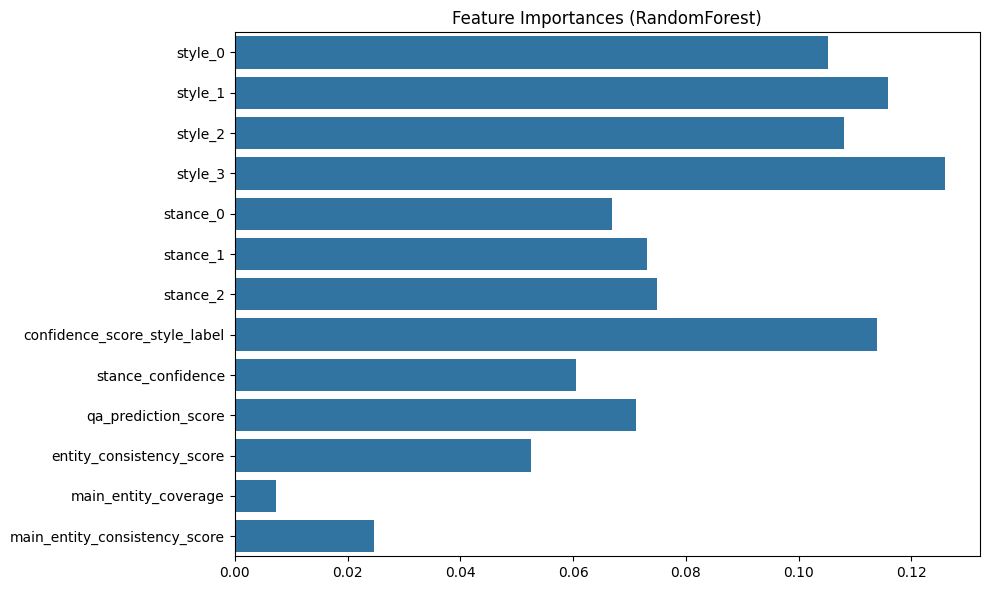

In [36]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

if not os.path.exists('clickbait_features.csv'):
    if 'features_df' in globals():
        print("Saving 'features_df' to 'clickbait_features.csv'...")
        features_df.to_csv('clickbait_features.csv', index=False)
        print("'clickbait_features.csv' saved successfully.")
    else:
        raise FileNotFoundError("features_df not found in global scope. Cannot create 'clickbait_features.csv'.")

# -----------------------------------------
# 1. LOAD FEATURE DATA
# -----------------------------------------

df = pd.read_csv("clickbait_features.csv")

print("Loaded dataset:", df.shape)

def safe_parse_list(x):
    try:
        return ast.literal_eval(x)
    except:
        return [0,0,0,0]

def safe_parse_dict(x):
    try:
        d = ast.literal_eval(x)
        return list(d.values())
    except:
        return [0,0,0]

df["probability_each_style"] = df["probability_each_style"].apply(safe_parse_list)
df["probability_each_stance"] = df["probability_each_stance"].apply(safe_parse_dict)

# -----------------------------------------
# 2. BUILD NUMERIC FEATURE MATRIX
# -----------------------------------------

style_features = np.vstack(df["probability_each_style"].values)
stance_features = np.vstack(df["probability_each_stance"].values)

other_features = df[
    [
        "confidence_score_style_label",
        "stance_confidence",
        "qa_prediction_score",
        "entity_consistency_score",
        "main_entity_coverage",
        "main_entity_consistency_score",
    ]
].values

X = np.hstack([style_features, stance_features, other_features])

label_mapping = {'non-clickbait': 0, 'clickbait': 1}
df['label'] = df['label'].map(label_mapping)
y = df["label"].astype(int).values

feature_names = (
    [f"style_{i}" for i in range(style_features.shape[1])] +
    [f"stance_{i}" for i in range(stance_features.shape[1])] +
    list(df[
        [
            "confidence_score_style_label",
            "stance_confidence",
            "qa_prediction_score",
            "entity_consistency_score",
            "main_entity_coverage",
            "main_entity_consistency_score",
        ]
    ].columns)
)

print("Final feature matrix:", X.shape)

# -----------------------------------------
# 3. TRAIN–VALIDATION SPLIT
# -----------------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------
# 4. SCALING
# -----------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# -----------------------------------------
# 5. TRAIN BASELINE MODELS
# -----------------------------------------

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}

results = []

for name, model in models.items():
    print(f"\n===== Training {name} =====")

    if name == "LogisticRegression":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="macro")

    results.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1
    })

    print("\nClassification Report:")
    print(classification_report(y_val, preds))

results_df = pd.DataFrame(results)
print("\n\n===== MODEL COMPARISON =====")
print(results_df)

# -----------------------------------------
# 6. SELECT BEST MODEL
# -----------------------------------------

best_row = results_df.sort_values("f1_macro", ascending=False).iloc[0]
best_name = best_row["model"]
print(f"\nBest model selected: {best_name}")

best_model = models[best_name]

joblib.dump(best_model, "clickbait_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")

print("Saved: clickbait_classifier.pkl & feature_scaler.pkl")

# -----------------------------------------
# 7. FEATURE IMPORTANCE
# -----------------------------------------

if best_name in ["RandomForest", "XGBoost"]:
    importances = best_model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names)
    plt.title(f"Feature Importances ({best_name})")
    plt.tight_layout()
    plt.show()
else:
    print("Logistic Regression was best — plot coefficients instead.")

## Integrate All Components into a Single Prediction Function

In [37]:
import joblib
import numpy as np

# Load the trained model and scaler
best_model = joblib.load('clickbait_classifier.pkl')
scaler = joblib.load('feature_scaler.pkl')

print("Trained model and scaler loaded successfully.")
print(f"Loaded model type: {type(best_model).__name__}")

Trained model and scaler loaded successfully.
Loaded model type: RandomForestClassifier


In [42]:
def predict_clickbait(title: str, content: str):
    if 'clickbait_pipeline' not in globals():
        raise RuntimeError("clickbait_pipeline not initialized. Please run the pipeline initialization cells first.")

    # 1. Obtain extracted features using the pipeline
    features_dict = clickbait_pipeline.predict(title, content)

    # 2. Extract relevant numerical features
    style_probs = features_dict['probability_each_style']
    stance_probs_dict = features_dict['probability_each_stance']
    stance_probs = [stance_probs_dict[k] for k in ['Agrees', 'Disagrees', 'Discusses']]

    confidence_score_style_label = features_dict['confidence_score_style_label']
    stance_confidence = features_dict['stance_confidence']
    qa_prediction_score = features_dict['qa_prediction_score']
    entity_consistency_score = features_dict['entity_consistency_score']
    main_entity_coverage = features_dict['main_entity_coverage']
    main_entity_consistency_score = features_dict['main_entity_consistency_score']

    # 3. Combine into a single feature vector
    feature_vector = np.array([
        *style_probs,
        *stance_probs,
        confidence_score_style_label,
        stance_confidence,
        qa_prediction_score,
        entity_consistency_score,
        main_entity_coverage,
        main_entity_consistency_score
    ]).reshape(1, -1)

    # 4. Scale features if the best model was LogisticRegression
    if type(best_model).__name__ == "LogisticRegression":
        processed_features = scaler.transform(feature_vector)
    else:
        processed_features = feature_vector

    # 5. Make prediction
    prediction = best_model.predict(processed_features)[0]
    prediction_proba = best_model.predict_proba(processed_features)[0]

    # Map prediction back to labels
    label_map_inv = {0: 'non-clickbait', 1: 'clickbait'}
    predicted_label = label_map_inv[prediction]

    return predicted_label, prediction_proba

In [43]:
sample_title = "Wakil Menkeu : Kenaikan Iuran BPJS Tidak Akan Berpengaruh pada Penduduk Miskin"
sample_content = """Jelang akhir tahun kabar kenaikan tarif iuran Badan Penyelenggara Jaminan Sosial (BPJS) Kesehatan bagi peserta program Program Jaminan Kesehatan Nasional-Kartu Indonesia Sehat (JKN-KIS). Seperti diketahui, kenaikan tarif ini rencananya akan berlaku mulai awal tahun 2020.,,Direktur Utama BPJS Kesehatan Fachmi Idris, mengatakan bahwa kenaikan tarif ini merupakan salah satu siasat untuk mengatasi defisit BPJS Kesehatan dari tahun ke tahun. Seperti diketahui, Dewan Jaminan Sosial Nasional (DJSN) mengusulkan kenaikan iuran kelas I Rp120 ribu, kelas II sebesar Rp75 ribu, sedangkan kelas III Rp42 ribu.,,Sementara untuk rincian kenaikan yang diusulkan oleh Menteri Keuangan yakni Kelas I naik dari Rp80 ribu menjadi Rp160 ribu, kelas II dari Rp51 ribu menjadi Rp110 ribu dan kelas III menjadi Rp42 ribu dari Rp30 ribu. Besaran ini naik dua kali lipat dari tarif sebelumnya.,,,Meski demikian, Wakil Menteri Keuangan Prof. Dr. Mardiasmo, mengatakan bahwa bahwa penyesuaian atau kenaikan tarif ini tidak akan membebani masyarakat miskin atau tidak mampu.,,"luran BPIS untuk 134 juta ilwa penduduk tidak mampu dibayarkan oleh APBN dan APBD. Kenaikan iuran ini tidak akan memengaruhi penduduk tidak mampu," ungkap Mardiasmo saat Forum Merdeka Barat (FMB) 9 dengan tema 'Tarif luran BPJS', Senin, 7 Oktober 2019.,,Ia menjelaskan saat ini sebanyak 96.6 juta penduduk tidak mampu iurannya dibayar oleh Pemerincah Pusat (APBN). Sementara itu 37,3 juta jiwa iurannya dibayarkan oleh Pemda (APBD).,,,Di sisi lain, Pemerintah Daerah juga memegang peranan penting untuk mengawal keberlanjutan Program JKN - KIS, termasuk memastikan kebijakan pemerintah pusat soal penyesuaian iuran ini nantinya dapat terimplementasikan dengan baik di masing-masing wilayah.,,,"""

predicted_label, probabilities = predict_clickbait(sample_title, sample_content)

print(f"\nPrediction for: '{sample_title}'")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Probabilities (non-clickbait, clickbait): {probabilities}")


Prediction for: 'Wakil Menkeu : Kenaikan Iuran BPJS Tidak Akan Berpengaruh pada Penduduk Miskin'
Predicted Label: non-clickbait
Prediction Probabilities (non-clickbait, clickbait): [0.72 0.28]


## Predict on the Full Dataset and Visualize Results

In [44]:
from tqdm.notebook import tqdm

predicted_labels_list = []
predicted_probs_clickbait_list = []
predicted_probs_non_clickbait_list = []

print(f"\n{'='*60}")
print(f"Generating predictions for {len(df)} articles...")
print(f"{'='*60}\n")

for index, row in tqdm(df.iterrows(), total=len(df), desc="Predicting clickbait"):
    title = row['title']
    content = row['content']

    try:
        predicted_label, probabilities = predict_clickbait(title, content)
        predicted_labels_list.append(predicted_label)
        predicted_probs_non_clickbait_list.append(probabilities[0])
        predicted_probs_clickbait_list.append(probabilities[1])
    except Exception as e:
        predicted_labels_list.append('error')
        predicted_probs_non_clickbait_list.append(np.nan)
        predicted_probs_clickbait_list.append(np.nan)
        print(f"Error predicting for article {index}: {e}")

df_predictions = df.copy()
df_predictions['predicted_label'] = predicted_labels_list
df_predictions['probability_non_clickbait'] = predicted_probs_non_clickbait_list
df_predictions['probability_clickbait'] = predicted_probs_clickbait_list

print("\nPredictions generated successfully. Displaying head of df_predictions:")
display(df_predictions.head())


Generating predictions for 15240 articles...



Predicting clickbait:   0%|          | 0/15240 [00:00<?, ?it/s]


Predictions generated successfully. Displaying head of df_predictions:


,title,label,content,entity_consistency_score,main_entity_coverage,main_entity_consistency_score,style_label,confidence_score_style_label,probability_each_style,stance,stance_confidence,probability_each_stance,qa_prediction_score,predicted_label,probability_non_clickbait,probability_clickbait
0,Anak Penjaga Kebersihan Masjid Lantamal 1 Bela...,1,Setelah dihebohkan dengan kemunculan calon tar...,0.00,0.0,0.00,factual,0.999823,"[2.3643891836400144e-05, 0.9998226761817932, 8...",Agrees,0.9827,"[0.9827, 0.0043, 0.013]",0.461609,clickbait,0.156667,0.843333
1,Wakil Menkeu : Kenaikan Iuran BPJS Tidak Akan ...,0,Jelang akhir tahun kabar kenaikan tarif iuran...,0.73,1.0,0.74,factual,0.999917,"[1.5275463738362305e-05, 0.9999173879623413, 4...",Discusses,0.9007,"[0.0981, 0.0012, 0.9007]",0.673288,non-clickbait,0.810000,0.190000
2,"Pendukung Jokowi Ngaku Diculik di Masjid, Ini ...",1,Pengurus Dewan Kemakmuran Masjid (DKM) Al-Fala...,0.72,1.0,0.74,factual,0.999861,"[1.6058804249041714e-05, 0.9998606443405151, 4...",Agrees,0.7808,"[0.7808, 0.0052, 0.214]",0.068362,clickbait,0.156667,0.843333
3,"Sebentar Lagi, Minyak Curah Dilarang, Warga Ha...",1,Menteri Perdagangan Enggartiasto Lukita melara...,0.90,1.0,0.90,factual,0.999949,"[1.4447236935666297e-05, 0.9999492168426514, 1...",Agrees,0.9665,"[0.9665, 0.0033, 0.0302]",0.800985,non-clickbait,0.670000,0.330000
4,Ya Tuhan... Hubungan Sedarah di Sumut Meningka...,1,"Miris, meski dianggap tabu dalam agama maupun ...",0.73,1.0,0.78,sensational,0.983300,"[0.9833000898361206, 0.00044391152914613485, 0...",Agrees,0.9698,"[0.9698, 0.0046, 0.0256]",0.089081,clickbait,0.036667,0.963333


In [52]:
df_predictions.to_csv('df_predictions.csv', index=False)

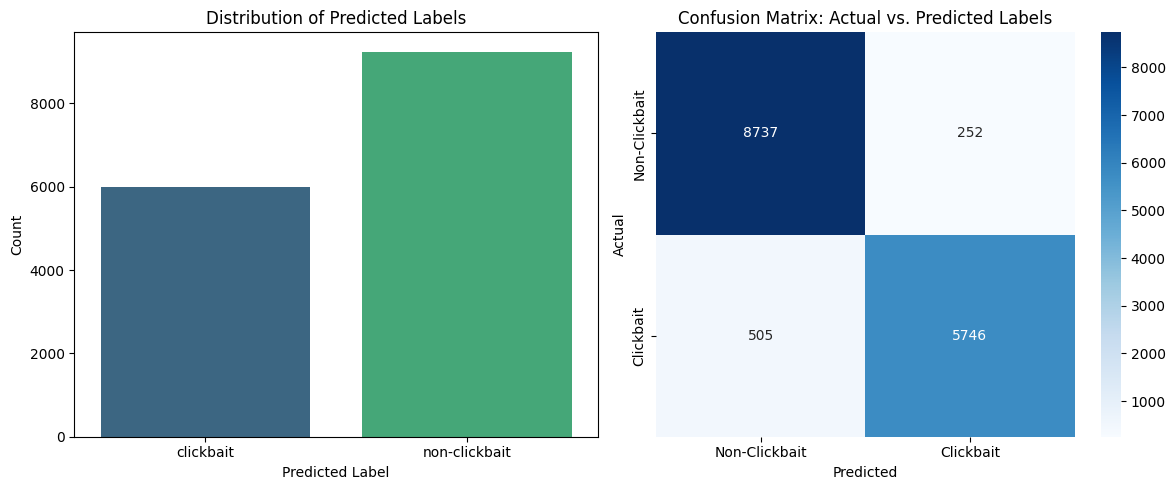

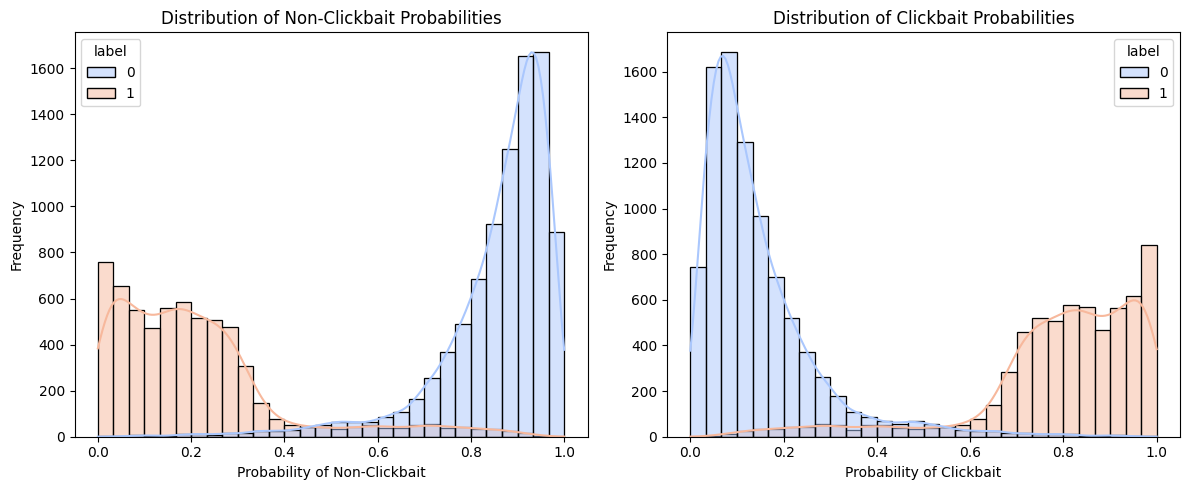

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

df_filtered = df_predictions.dropna(subset=['predicted_label'])

y_true = df_filtered['label'].astype(int)

predicted_label_mapping = {'non-clickbait': 0, 'clickbait': 1}
df_filtered['predicted_label_encoded'] = df_filtered['predicted_label'].map(predicted_label_mapping)

y_pred = df_filtered['predicted_label_encoded'].astype(int)

# 1. Distribution of Predicted Labels
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='predicted_label', data=df_filtered, palette='viridis')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Clickbait', 'Clickbait'],
            yticklabels=['Non-Clickbait', 'Clickbait'])
plt.title('Confusion Matrix: Actual vs. Predicted Labels')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 3. Distribution of Prediction Probabilities
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_filtered, x='probability_non_clickbait', hue='label', bins=30, kde=True, palette='coolwarm')
plt.title('Distribution of Non-Clickbait Probabilities')
plt.xlabel('Probability of Non-Clickbait')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_filtered, x='probability_clickbait', hue='label', bins=30, kde=True, palette='coolwarm')
plt.title('Distribution of Clickbait Probabilities')
plt.xlabel('Probability of Clickbait')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()